Understanding 4D4L's Domain Objects
====================================

4D4L represents warehouse data through **domain objects**. Understanding these is essential to use the library.

Storage Locations
-----------------

Storage locations define where articles are physically stored in your warehouse.


In [7]:
from ware_ops_algos.domain_models import Location, StorageLocations, StorageType

# A single storage location
location = Location(
   x=1,          # Aisle number
   y=3,          # Position along the aisle
   article_id=1, # Which article is stored here
   amount=10     # Quantity available
)

# Collection of all locations in the warehouse
storage = StorageLocations(
   StorageType.DEDICATED,  # or StorageType.SCATTERED
   locations=[location]
)

Orders
------

Orders represent what customers ordered and need to be picked.

In [8]:
from ware_ops_algos.domain_models import Order, OrderPosition, OrdersDomain, OrderType

# What was ordered
order_position = OrderPosition(
    order_number=1,
    article_id=5,
    amount=2
)

# Complete order with all positions
order = Order(
    order_id=1,
    order_positions=[order_position]
)

# Collection of all orders
orders = OrdersDomain(
    OrderType.STANDARD,
    orders=[order]
)

Resources
---------

Resources represent pickers (humans or robots) who fulfill orders.

In [9]:
from ware_ops_algos.domain_models import Resource, PickCart, DimensionType, Resources, ResourceType

PICKER_CAPACITY = 10
pick_cart = PickCart(n_dimension=1,
                     n_boxes=1,
                     capacities=[PICKER_CAPACITY],
                     dimensions=[DimensionType.ITEMS])
resources_list = [
    Resource(id=0, speed=1.0, pick_cart=pick_cart)]

resources = Resources(ResourceType.HUMAN, resources_list)

Layout (for routing algorithms)
--------------------------------

Some routing algorithms need layout parameters to calculate distances.


In [10]:
from ware_ops_algos.generators import ShelfStorageGraphGenerator

graph_gen = ShelfStorageGraphGenerator(n_aisles=10,
                                   n_pick_locations=10,
                                   dist_aisle=1,
                                   dist_pick_locations=1,
                                   dist_aisle_location=1,
                                   dist_start=1,
                                   dist_end=1,
                                   start_location=(1,-1),
                                   end_location=(2,-1),
                                   )

graph_gen.populate_graph()

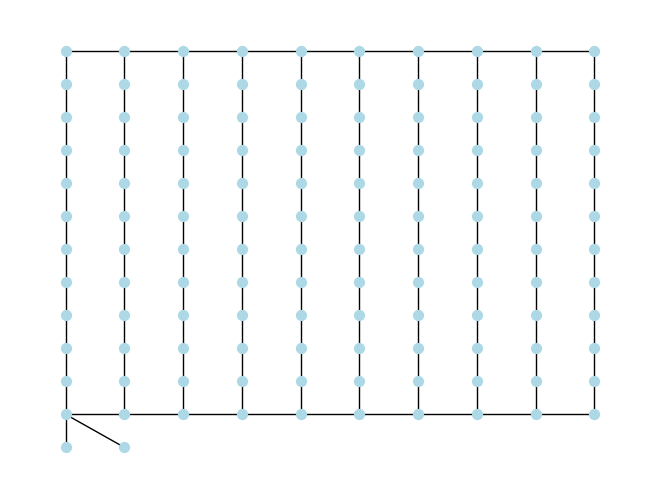

In [11]:
from ware_ops_algos.utils.visualization import render_graph

render_graph(graph_gen.G)

Complete Example
================

In [12]:
from ware_ops_algos.algorithms import RatliffRosenthalRouting, GreedyItemAssignment
from ware_ops_algos.domain_models import (
    Location, StorageLocations, StorageType,
    Order, OrderPosition, OrdersDomain, OrderType,
    Resource
)

# 1. Define where articles are stored
locations_list = [
    Location(x=1, y=3, article_id=1, amount=1),
    Location(x=1, y=8, article_id=2, amount=1),
    Location(x=2, y=5, article_id=3, amount=1),
]
storage_locations = StorageLocations(StorageType.DEDICATED, locations=locations_list)
storage_locations.build_article_location_mapping()

# 2. Define what was ordered
order_positions = [
    OrderPosition(order_number=1, article_id=1, amount=1),
    OrderPosition(order_number=1, article_id=2, amount=1),
    OrderPosition(order_number=1, article_id=3, amount=1),
]
order = Order(order_id=1, order_positions=order_positions)
orders = OrdersDomain(OrderType.STANDARD, orders=[order])

# 3. Map order positions to physical locations
#    (This step resolves "I need article 1" to "Pick from location x=1, y=3")
selector = GreedyItemAssignment(storage_locations)
ia_solution = selector.solve(orders.orders)
orders.orders = ia_solution.resolved_orders

# 4. Create pick list for routing
pick_list = [pos for pos in orders.orders[0].pick_positions]

# 5. Calculate optimal route
router = RatliffRosenthalRouting(
    distance_matrix=None,
    predecessor_matrix=None,
    start_node=(0, 0),
    end_node=(4, 0),
    closest_node_to_start=(0, 0),
    min_aisle_position=1,
    max_aisle_position=6,
    picker=[Resource(id=1)],
    n_aisles=6,
    n_pick_locations=15,
    dist_aisle=2,
    dist_pick_locations=1,
    dist_aisle_location=1,
    dist_start=1,
    dist_end=1
)

solution = router.solve(pick_list)

print(f"Total distance: {solution.route.distance}")

Total distance: 30


# Implemented Algorithms

In [13]:
from ware_ops_algos.utils.general_functions import load_model_cards

all_algorithms = load_model_cards("../../src/project_4D4L/algorithms/algorithm_cards")

In [14]:
problems = {}
for algo in all_algorithms:
   if algo.problem_type not in problems.keys():
      problems[algo.problem_type] = [algo]
   else:
      problems[algo.problem_type].append(algo)

for problem in problems.keys():
   print(problem)
   for a in problems[problem]:
      print(a.model_name)
   print()

batching
ClarkAndWrightNN
ClarkAndWrightRR
ClarkAndWrightSShape
ClosestDepotMaxSharedArticlesSeedBatching
ClosestDepotMinDistanceSeedBatching
CombinedBatchingRoutingAssigning
DueDate
FiFo
LSBatchingNNDueDate
LSBatchingNNFiFo
LSBatchingNNRand
LSBatchingRR
OrderNrFiFo
Random
RandomMinDistanceSeedBatching
RandomSimArticlesSeedBatching

sequencing
EDDScheduling
EDDSequencing
LPTScheduling
SimpleSequencing
SPTScheduling

item_assignment
GreedyItemAssignment
NNItemAssignment

routing
LargestGap
Midpoint
NearestNeighbourhood
Return
RatliffRosenthal
SPRPNF
SShape
ExactSolving

assignment
RRAssigner

